In [1]:
# Load trajectories into MDAnalysis universe

import MDAnalysis as mda
from MDAnalysis.analysis import align, rms

dir_prefix = '../trajectories/'
directories = {'dC_init': dir_prefix+'complex_preliminary/',
               'dC': dir_prefix + 'complex-dC/',
               'dC_dH': dir_prefix + 'complex-dC-dH/'}
segments = {'FTSQ':92,'FTSL':120,'FTSB':74,'FTSW':41,'PBPB':79,'PERM':10}
save_dir = '../data/divisome-complex-angle/'

universes = {}
conditions = list(directories.keys())

ref = mda.Universe(directories['dC_init']+'protein-only-initial-frame.pdb',directories['dC_init']+'protein-only.dcd')
for s in segments.keys():
            ref.select_atoms('segid ' + s).residues.resids += segments[s]-1
for c in conditions:

    universes[c] = mda.Universe(directories[c]+'protein-only-initial-frame.pdb',directories[c]+'protein-only.dcd')

    # initial simulation was numbered started with 1
    if c=='dC_init':
        segments = {'FTSQ':92,'FTSL':120,'FTSB':74,'FTSW':41,'PBPB':79,'PERM':10}
        for s in segments.keys():
            universes['dC_init'].select_atoms('segid ' + s).residues.resids += segments[s]-1
        

/Users/zach/miniconda3/envs/datascience/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/zach/miniconda3/envs/datascience/lib/python3.12/site-packages/Bio/Application/__init__.py:40: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(
/Users/zach/miniconda3/envs/datascience/lib/python3.12/site-packages/MDAnalysis/topology/PDBParser.py:331: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDA

In [2]:
# Align by FTSW CA atoms for residues 60-407 excluding cytoplasmic terminal residues

import MDAnalysis as mda
from MDAnalysis.analysis import align, rms

sele = 'segid FTSW and resid 60-407 and name CA'

ref.trajectory[0]
ref_ca = ref.select_atoms(sele)

for c in conditions:
    
    print('\n' + c)
    universes[c].trajectory[-1]
    mobile_ca = universes[c].select_atoms(sele)

    unaligned_rmsd = rms.rmsd(mobile_ca.positions, ref_ca.positions, superposition=False)
    print(f"Unaligned RMSD: {unaligned_rmsd:.2f}")

    aligner = align.AlignTraj(universes[c], ref, select=sele, in_memory=True).run()
    universes[c].trajectory[-1]

    aligned_rmsd = rms.rmsd(mobile_ca.positions, ref_ca.positions, superposition=False)
    print(f"Aligned RMSD: {aligned_rmsd:.2f}")



dC_init
Unaligned RMSD: 18.27
Aligned RMSD: 1.69

dC
Unaligned RMSD: 17.31
Aligned RMSD: 2.16

dC_dH
Unaligned RMSD: 13.64
Aligned RMSD: 2.13


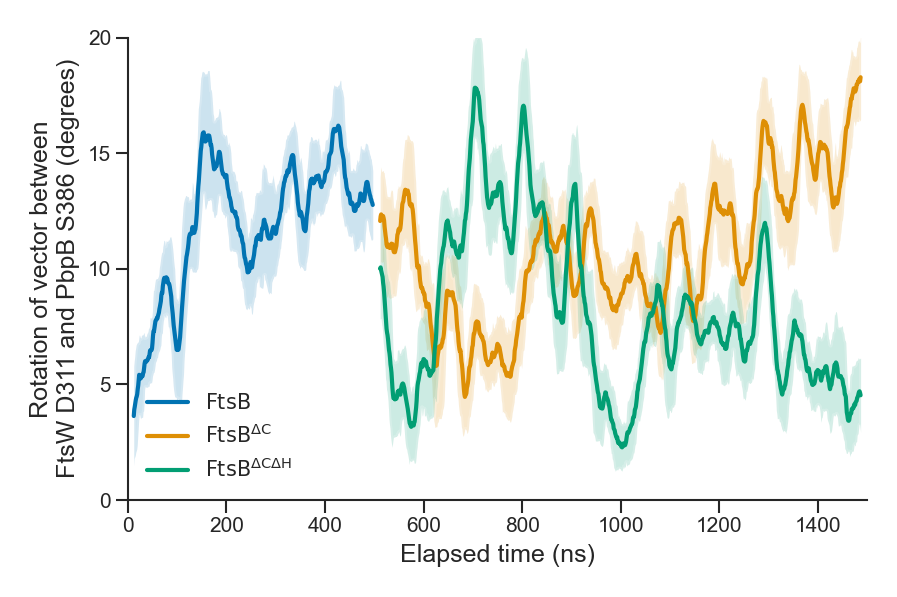

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from numpy.linalg import norm

sns.set_theme(style='ticks',
              palette=sns.color_palette('colorblind'),
              font='Arial',
              rc={'figure.dpi': 300,
                  'figure.figsize':(7.2,4), # 7.2 inch is full page width
                  'axes.spines.right':False,
                  'axes.spines.top':False,
                  'axes.linewidth':0.5,
                  'font.size':7,
                  'xtick.labelsize':5,
                  'ytick.labelsize':5,
                  'xtick.major.pad':1,
                  'ytick.major.pad':1,
                  'xtick.major.size':3,
                  'ytick.major.size':3,
                  'xtick.minor.size':2,
                  'ytick.minor.size':2,
                  'xtick.major.width':0.5,
                  'ytick.major.width':0.5,
                  'xtick.minor.width':0.5,
                  'ytick.minor.width':0.5,
                  'axes.titlesize':6,
                  'axes.labelsize':6,
                  'legend.fontsize':5,
                  'legend.title_fontsize':6,
                  'axes.labelpad':2})

def theta(v, w): return 180*np.arccos(v.dot(w)/(norm(v)*norm(w)))/np.pi

labels = {'dC_init': r'$\text{FtsB}$',
               'dC': r'$\text{FtsB}^\text{ΔC}$',
               'dC_dH': r'$\text{FtsB}^\text{ΔCΔH}$'}

figure_prefix = '../figures/figure-5/'
stride = 10 # using every frame rather than every 10th frame makes NO difference in 25-ns averages
window_width = 25 # in nanoseconds sliding window
window_std = 25

sele_1 = 'segid FTSW and resid 311 and name CA'
sele_2 = 'segid PBPB and resid 386 and name CA'

ref.trajectory[0]
x0 = ref.select_atoms(sele_2).positions[0] - ref.select_atoms(sele_1).positions[0]

t0 = 500
dt = 0.1 * stride
window_width = int(window_width / dt)
window_std = int(window_std/dt)

fig = plt.figure(figsize=(3,2))

cs = 'rgb'
for c in conditions:

    x1 = np.array([universes[c].select_atoms(sele_1).positions[0] for t in universes[c].trajectory[0::stride]])
    x2 = np.array([universes[c].select_atoms(sele_2).positions[0] for t in universes[c].trajectory[0::stride]])

    if c == 'dC_init':
        t = dt*np.arange(len(x1))
    else:
        t = dt*np.arange(len(x1)) + t0

    angle = np.array([theta(x0,x) for x in x2-x1])

    angle_avg = pd.Series(angle).rolling(window=window_width,center=True).mean()
    angle_std = pd.Series(angle).rolling(window=window_std,center=True).std()
    
    plt.fill_between(t,angle_avg-angle_std,angle_avg+angle_std,alpha=0.2)
    plt.plot(t,angle_avg,linewidth=1,label=labels[c])
    plt.legend(frameon=False)

    condition_data = pd.DataFrame({'time (ns)':list(t),'angle (degree)':list(angle), 'average angle':list(angle_avg), 'angle standard deviation':list(angle_std)})
    condition_data.to_csv(save_dir + c + '.tsv',sep='\t',float_format='%0.3f')
    

plt.xlim([0,1500])
plt.ylim([0,2])
plt.yticks([0,5,10,15,20])
plt.xlabel('Elapsed time (ns)')
plt.ylabel('Rotation of vector between\nFtsW D311 and PbpB S386 (degrees)')

plt.tight_layout()

plt.savefig(figure_prefix + 'TPase_tilt.png',dpi=300)
plt.savefig(figure_prefix + 'TPase_tilt.svg',dpi=300)
